# Project

# Data

The dataset<sup><a name="note-cariboo" href="#cariboo">[7]</a></sup> is composed of 7 different subsets, we will be using 4 of the datasets. Since each feature resides in different sets. 

- `Appearances.csv`
    - Player ID, Game ID, Appearance ID, Competition ID, Player club ID, Assist, Minutes Played, Yellow cards, Red Cards
- `Clubs.csv `
    - Club ID, Name, Pretty_name, Domestic_competition_id, Total_market_value, Squad_size, Average_age, Foreigners_numbers, Foreigners_percentage, National_team_players, Stadium_name, Stadium_seats, Net_transfer_record, Coach_name, URL
- `Competitions.csv`
    - Competition_id, Name, type, country_id, country_name, domestic_league_code, confederation, URL.  
- `Games.csv` 
    - Game_id, Competition_code, Season, Round, Date, Home_club_id, Away_club_id, Home_club_goals, away_club_goals, Home_club_postions, Away_club_postion, Stadium, Attendance, Referee, URL 
- `Leagues.csv` 
    - League_id, name, Confederation
- `Player_valuations.csv` 
    - Player_id, Date, Market_value
- `Players.csv`
    - Player_id, Last_season, Current_club_id, Name, Pretty_name, country_of_birth, Country_of_citizenship, Date_of_birth, Position, Sub_position, Foot, Height_in_cm, Market_value_in_gbp, Highest_market_value_in_gbp, URL

- _What an observation consists of_: We are trying to use the variables we assume to be the most important and independent from each other. We decided on 
    - Club, Nationality, League, Appearances, Minutes, Goals, Assist, Age, Conduct, Media Presence, Years Played, Trophies, Experience, Position, Physicality, Potential. 
- _What some critical variables are, how they are represented_: We want variables which have the highest co-variance with each other. The metric should handle most features as unique features. 
- _Any special handling, transformations, cleaning, etc will be needed_: There will be club names, and probably inferences in our data. Such as Media Presence or Potential, these are metrics which can be objective to the person. How popular is the player that we are analyzing? 

We are still going to be in search of more databases that might have different descriptive data that we might like to see how organizations search for talent. We can use what they might describe as their most sought out characteristics. 

For Simplicity we can also assume that all players have no contracts for their evaluation and are based solely on performance and the other variables mentioned.

In [1]:
!{__import__('sys').executable} -m pip install --quiet pandas

In [2]:
import pandas as pd

_data_ = {
    name: pd.read_csv(
        file, 
        engine = 'c',
        low_memory = True,
        memory_map = False, # set `False` to load into memory
        **kwargs
    ) for name, file, kwargs in [
        ('appearances', 'data/appearances.csv', {}),
        ('clubs', 'data/clubs.csv', {}),
        ('competitions', 'data/competitions.csv', {}),
        ('games', 'data/games.csv', {}),
        ('leagues', 'data/leagues.csv', {}),
        ('players', 'data/players.csv', {
            'parse_dates': ['date_of_birth'],
            'dtype': {
                'last_season': 'category',
                'country_of_birth': 'category',
                'country_of_citizenship': 'category',
                'position': 'category',
                'sub_position': 'category'
            }
        }),
        ('player_valuations', 'data/player_valuations.csv', {})
    ]
}

In [3]:
data = {}

In [4]:
data['clubs'] = _data_['clubs'].copy()

data['clubs'] = data['clubs'][['club_id', 'name']]
data['clubs'].rename(
    columns = {'name': 'club_name'},
    inplace = True
)
data['clubs'].set_index('club_id', inplace = True)

data['clubs']

,club_name
club_id,
1032,fc-reading
2323,orduspor
1387,acn-siena-1904
3592,kryvbas-kryvyi-rig
1071,wigan-athletic
...,...
1269,pec-zwolle
200,fc-utrecht
317,fc-twente-enschede


In [5]:
data['games'] = _data_['games'].copy()

data['games'] = data['games'][[
    'season', 
    'game_id', 
    'home_club_id', 
    'away_club_id'
]]
data['games'].set_index('game_id', inplace = True)

data['games']

,season,home_club_id,away_club_id
game_id,,,
2244388,2012,131,418
2219794,2011,58,498
2244389,2012,418,131
2271112,2012,48,60
2229332,2012,27,16
...,...,...,...
3646190,2021,84351,1053
3646188,2021,5791,20108
3655616,2021,5874,12275


In [6]:
data['appearances'] = _data_['appearances'].copy()

data['appearances'] = data['appearances'].loc[
    :, ~data['appearances'].columns.isin([
        'appearance_id', 
        'competition_id'
    ])
]
data['appearances'].rename(
    columns = {'player_club_id': 'club_id'},
    inplace = True
)

data['appearances'] = data['appearances'].merge(
    data['games'], 
    on = 'game_id',
    copy = False
)
data['appearances'].drop(columns = 'game_id', inplace = True)

data['appearances'] = (
    data['appearances']
        .groupby(['player_id', 'season'])
        .agg({
            **{
                c: 'sum' for c in [
                    'goals', 
                    'assists', 
                    'minutes_played', 
                    'yellow_cards', 
                    'red_cards'
                ]
            },
            'club_id': 'last',
            'home_club_id': 'last',
            'away_club_id': 'last'
        })
)

data['appearances'].reset_index('season', inplace = True)

data['appearances']

,season,goals,assists,minutes_played,yellow_cards,red_cards,club_id,home_club_id,away_club_id
player_id,,,,,,,,,
10,2014,16,9,2289,6,0,398,398,9690
10,2015,8,7,1714,3,0,398,4102,398
26,2014,0,0,2880,0,0,16,15,16
26,2015,0,0,1260,1,0,16,16,1058
26,2016,0,0,1020,0,0,16,16,167
...,...,...,...,...,...,...,...,...,...
926954,2021,0,0,24,1,0,2778,2778,5724
926987,2021,0,0,3,0,0,1053,1053,206
934034,2021,0,0,3,0,0,60949,3385,60949


In [7]:
data['player_valuations'] = _data_['player_valuations'].copy()

data['player_valuations']['season'] = \
    pd.DatetimeIndex(data['player_valuations']['date']).year
data['player_valuations'].drop(columns = 'date', inplace = True)

data['player_valuations'] = (
    data['player_valuations']
        .groupby(['player_id', 'season'])
        .agg({'market_value': 'mean'})
)
data['player_valuations'].reset_index('season', inplace = True)

data['player_valuations'].rename(
    columns = {'market_value_in_gbp': 'market_value'},
    inplace = True
)

data['player_valuations']

,season,market_value
player_id,,
10,2004,6300000.0
10,2005,10800000.0
10,2006,22500000.0
10,2007,20700000.0
10,2008,18000000.0
...,...,...
928831,2021,45000.0
928831,2022,45000.0
934034,2021,45000.0


In [8]:
data['players'] = _data_['players'].copy()

data['players'] = data['players'].loc[
    :, ~data['players'].columns.isin([
        'last_season',
        'pretty_name',
        'current_club_id',
        'market_value_in_gbp',
        'highest_market_value_in_gbp',
        'country_of_birth',
        'url', 
        'foot'
    ])
]
data['players'].rename(
    columns = {
        'height_in_cm': 'height',
        'country_of_citizenship': 'nationality'
    },
    inplace = True
)

data['players'].set_index('player_id', inplace = True)

data['players']

,name,nationality,date_of_birth,position,sub_position,height
player_id,,,,,,
254016,arthur-delalande,France,1992-05-18,Midfield,midfield - Central Midfield,186
51053,daniel-davari,Iran,1988-01-06,Goalkeeper,Goalkeeper,192
31451,torsten-oehrl,Germany,1986-01-07,Attack,attack - Centre-Forward,192
44622,vladimir-kisenkov,Russia,1981-10-08,Defender,Defender - Right-Back,182
30802,oscar-diaz,Spain,1984-04-24,Attack,attack - Centre-Forward,183
...,...,...,...,...,...,...
462285,fabian-de-keijzer,Netherlands,2000-05-10,Goalkeeper,Goalkeeper,193
368612,merveille-bokadi,DR Congo,1996-05-21,Defender,Defender - Centre-Back,186
408574,joey-veerman,Netherlands,1998-11-19,Midfield,midfield - Central Midfield,185


In [9]:
data['all'] = data['players'].merge(
    data['player_valuations'].merge(
        data['appearances'], 
        on = ['player_id', 'season'],
        copy = False
    ), 
    on = 'player_id',
    copy = False
)
'''
.merge(
    data['clubs'], 
    on = 'club_id',
    copy = False
)
data['all'].drop(columns = 'club_id', inplace = True)
'''

data['all']['age'] = (
    pd.to_datetime(data['all']['season'], format = '%Y', utc = True) 
        - pd.to_datetime(data['all']['date_of_birth'], utc = True)
).astype('timedelta64[Y]')
data['all'].drop(columns = 'date_of_birth', inplace = True)

data['all']

,name,nationality,position,sub_position,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_id,home_club_id,away_club_id,age
player_id,,,,,,,,,,,,,,,,
9800,artem-milevskyi,Ukraine,Attack,attack - Centre-Forward,189,2020,90000.0,0,2,618,3,0,6131,6131,282,34.0
43084,gaetano-berardi,Switzerland,Defender,Defender - Right-Back,179,2020,360000.0,0,0,114,0,0,399,399,984,31.0
230826,gennaro-acampora,Italy,Midfield,midfield - Central Midfield,174,2020,360000.0,1,2,624,2,0,3522,3522,130,25.0
198087,matteo-ricci,Italy,Midfield,midfield - Defensive Midfield,176,2020,1530000.0,0,3,2440,5,0,3522,4083,3522,25.0
110689,deniz-mehmet,Turkey,Goalkeeper,Goalkeeper,192,2020,68000.0,0,0,540,0,0,1519,3016,1519,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364245,jordan-teze,Netherlands,Defender,Defender - Centre-Back,183,2019,420000.0,0,0,180,0,0,383,383,2761,19.0
364245,jordan-teze,Netherlands,Defender,Defender - Centre-Back,183,2020,1102500.0,0,1,3747,5,0,383,141,383,20.0
364245,jordan-teze,Netherlands,Defender,Defender - Centre-Back,183,2021,5400000.0,1,4,2630,6,0,383,383,132,21.0


In [10]:
#one hot encode categorical features
data['all'] = pd.get_dummies(data['all'], columns = ['position', 'sub_position', 'nationality'])
data['all']

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_id,...,nationality_Uganda,nationality_Ukraine,nationality_United States,nationality_Uruguay,nationality_Uzbekistan,nationality_Venezuela,nationality_Vietnam,nationality_Wales,nationality_Zambia,nationality_Zimbabwe
player_id,,,,,,,,,,,,,,,,,,,,,
9800,artem-milevskyi,189,2020,90000.0,0,2,618,3,0,6131,...,0,1,0,0,0,0,0,0,0,0
43084,gaetano-berardi,179,2020,360000.0,0,0,114,0,0,399,...,0,0,0,0,0,0,0,0,0,0
230826,gennaro-acampora,174,2020,360000.0,1,2,624,2,0,3522,...,0,0,0,0,0,0,0,0,0,0
198087,matteo-ricci,176,2020,1530000.0,0,3,2440,5,0,3522,...,0,0,0,0,0,0,0,0,0,0
110689,deniz-mehmet,192,2020,68000.0,0,0,540,0,0,1519,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364245,jordan-teze,183,2019,420000.0,0,0,180,0,0,383,...,0,0,0,0,0,0,0,0,0,0
364245,jordan-teze,183,2020,1102500.0,0,1,3747,5,0,383,...,0,0,0,0,0,0,0,0,0,0
364245,jordan-teze,183,2021,5400000.0,1,4,2630,6,0,383,...,0,0,0,0,0,0,0,0,0,0


In [11]:
data['all'].dtypes

name                      object
height                     int64
season                     int64
market_value             float64
goals                      int64
                          ...   
nationality_Venezuela      uint8
nationality_Vietnam        uint8
nationality_Wales          uint8
nationality_Zambia         uint8
nationality_Zimbabwe       uint8
Length: 202, dtype: object

In [12]:
data['all'].describe()

,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_id,home_club_id,...,nationality_Uganda,nationality_Ukraine,nationality_United States,nationality_Uruguay,nationality_Uzbekistan,nationality_Venezuela,nationality_Vietnam,nationality_Wales,nationality_Zambia,nationality_Zimbabwe
count,51841.000000,51841.000000,5.184100e+04,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,...,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000
mean,180.774156,2017.368897,3.569469e+06,1.911672,1.451573,1380.464690,2.952702,0.070562,3448.541020,4284.952316,...,0.000559,0.046700,0.004668,0.006443,0.000752,0.002701,0.000039,0.003221,0.000617,0.000772
std,17.814441,2.314096,8.201849e+06,3.649821,2.380698,1054.435695,3.041267,0.269955,7734.976976,9316.695975,...,0.023645,0.210999,0.068165,0.080009,0.027418,0.051897,0.006211,0.056666,0.024838,0.027767
min,0.000000,2013.000000,9.000000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,178.000000,2015.000000,3.600000e+05,0.000000,0.000000,397.000000,0.000000,0.000000,338.000000,373.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,182.000000,2017.000000,9.000000e+05,0.000000,0.000000,1256.000000,2.000000,0.000000,979.000000,1025.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,187.000000,2019.000000,3.000000e+06,2.000000,2.000000,2184.000000,5.000000,0.000000,2740.000000,3060.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,206.000000,2021.000000,1.800000e+08,61.000000,31.000000,5061.000000,23.000000,3.000000,75506.000000,91484.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#
data['all'][data['all']['name'] == 'lionel-messi']

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_id,...,nationality_Uganda,nationality_Ukraine,nationality_United States,nationality_Uruguay,nationality_Uzbekistan,nationality_Venezuela,nationality_Vietnam,nationality_Wales,nationality_Zambia,nationality_Zimbabwe
player_id,,,,,,,,,,,,,,,,,,,,,
28003,lionel-messi,169,2014,108000000.0,58,31,5061,6,0,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2015,108000000.0,41,24,4229,5,0,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2016,108000000.0,54,20,4452,9,0,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2017,108000000.0,45,20,4468,7,0,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2018,156000000.0,51,22,4024,3,0,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2019,130500000.0,30,25,3631,7,0,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2020,95400000.0,39,15,4373,6,1,131,...,0,0,0,0,0,0,0,0,0,0
28003,lionel-messi,169,2021,66000000.0,11,13,2692,1,0,583,...,0,0,0,0,0,0,0,0,0,0


# Evaluation Metrics

We will be using an OLS regression model and the evaluation techniques we are considering are RMSE and Euclidean distance.
A possible evaluation metric we will use is RMSE or Mean Absolute Value of Errors. It is derived by calculating the difference between the estimated and actual value, square those results, then calculate the mean of those results. The formula for RMSE is 

$$
    \text{RMSE} = \sqrt{\frac{\sum_{i = 1}^{N}\left(\text{Predicted}_{i} - \text{Actual}_{i}\right)^{2}}{N}}
$$

# Preliminary results

In [14]:
!{__import__('sys').executable} -m pip install --quiet statsmodels numpy seaborn

In [15]:
# OLS using statsmodels
import statsmodels.api as sm
import numpy as np

In [16]:
# feature selection
X = data['all'][[
    'goals', 
    'assists', 
    'minutes_played', 
    'yellow_cards', 
    'red_cards', 
    'height'
]]
y = data['all']['market_value']

X = sm.add_constant(X)

OLS_model = sm.OLS(y, X).fit()
OLS_model.summary()

# X coeffecients and constant terms for prediction/plot
params = OLS_model.params

print(OLS_model.summary())
print(params)

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     2437.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:05:30   Log-Likelihood:            -8.9242e+05
No. Observations:               51841   AIC:                         1.785e+06
Df Residuals:                   51834   BIC:                         1.785e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.382e+06   3.27e+05     -4.

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns

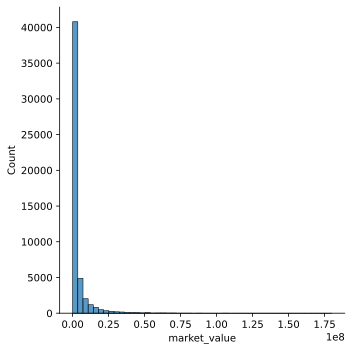

In [18]:
sns.displot(data = data['all'], x = 'market_value', bins = 50)

plt.show()

In [19]:
df_highest_market_value_players = data['all'].nlargest(n = 1, columns = 'market_value')

df_highest_market_value_players

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_id,...,nationality_Uganda,nationality_Ukraine,nationality_United States,nationality_Uruguay,nationality_Uzbekistan,nationality_Venezuela,nationality_Vietnam,nationality_Wales,nationality_Zambia,nationality_Zimbabwe
player_id,,,,,,,,,,,,,,,,,,,,,
342229,kylian-mbappe,178,2019,180000000.0,24,12,2051,2,0,583,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_highest_market_value = data['all'].loc[data['all']['name'].isin(df_highest_market_value_players['name'])]

df_highest_market_value

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_id,...,nationality_Uganda,nationality_Ukraine,nationality_United States,nationality_Uruguay,nationality_Uzbekistan,nationality_Venezuela,nationality_Vietnam,nationality_Wales,nationality_Zambia,nationality_Zimbabwe
player_id,,,,,,,,,,,,,,,,,,,,,
342229,kylian-mbappe,178,2015,45000.0,1,2,323,1,0,162,...,0,0,0,0,0,0,0,0,0,0
342229,kylian-mbappe,178,2016,1518750.0,21,8,2108,2,0,162,...,0,0,0,0,0,0,0,0,0,0
342229,kylian-mbappe,178,2017,40500000.0,17,10,2829,3,0,162,...,0,0,0,0,0,0,0,0,0,0
342229,kylian-mbappe,178,2018,138600000.0,37,14,3030,7,1,583,...,0,0,0,0,0,0,0,0,0,0
342229,kylian-mbappe,178,2019,180000000.0,24,12,2051,2,0,583,...,0,0,0,0,0,0,0,0,0,0
342229,kylian-mbappe,178,2020,162000000.0,35,11,3583,6,0,583,...,0,0,0,0,0,0,0,0,0,0
342229,kylian-mbappe,178,2021,144000000.0,31,25,3616,11,0,583,...,0,0,0,0,0,0,0,0,0,0


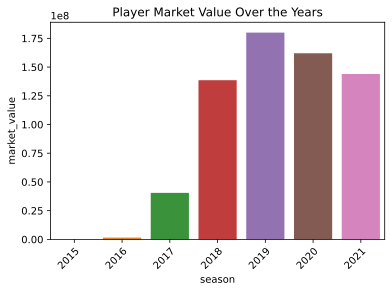

In [21]:
sns.barplot(data = df_highest_market_value, x = 'season', y = 'market_value')
plt.title('Player Market Value Over the Years')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()

# Footnotes

<sup><a name="cariboo" href="#note-cariboo">7</a></sup> *Football Data from Transfermarkt.* (2022, April 22). [Dataset]. https://www.kaggle.com/datasets/davidcariboo/player-scores